<a href="https://colab.research.google.com/github/urielmun/AI_lab/blob/main/Audio_Resampling%232.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**음성 리셈플링의 정의와 하는 이유**
시간에 따른 음성 파일을 얻을 수 있는데, 이것에는 frequency가 존재함. 천헤르츠를 다 저장할 수도 있고, 용량에 따라서 달라질 수 있음. 1초에 2개씩만 가져올 수도 있음. 내가 가진 정보로 표본을 구성하는 것을 리셈플링 이라고 한다. 늘리는 것도 리셈플링이라고함.


https://docs.pytorch.org/audio/stable/tutorials/audio_resampling_tutorial.html

In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.8.0+cu126
2.8.0+cu126


In [4]:
pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.7 MB/s eta 0:00:00


In [5]:
import math
import timeit

import librosa
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import resampy
from IPython.display import Audio

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    times, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                times.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    times.append(t_max)
    freq.append(f_max)
    return times, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):

    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)

/tmp/ipython-input-4283427226.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(file_path, sr=None, mono=mono)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


[LOAD] 095522039.m4a
 - shape: (177152,)
 - sample_rate: 44100


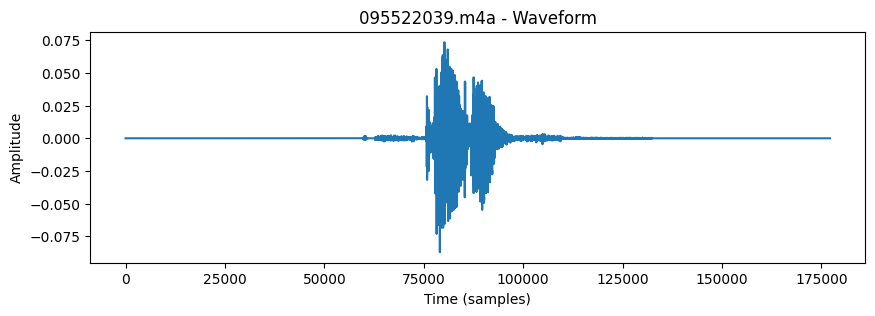

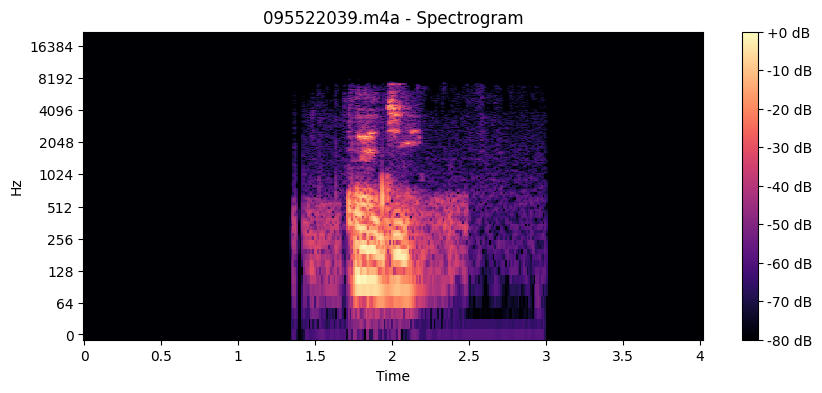

[RESAMPLE] 44100 Hz → 16000 Hz | shape: (64272,)
[RESAMPLE] 16000 Hz → 44100 Hz | shape: (177149,)


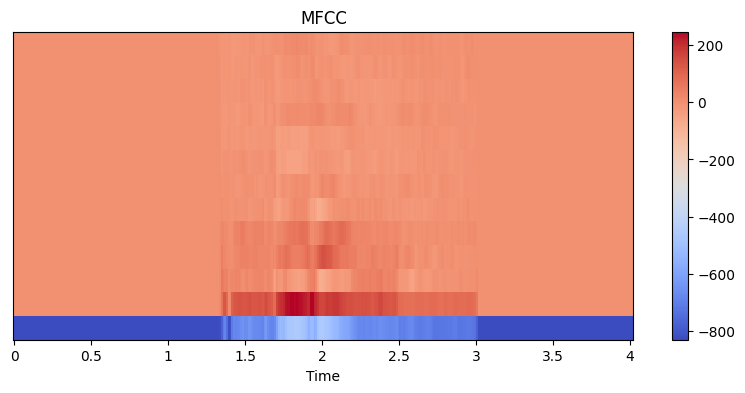

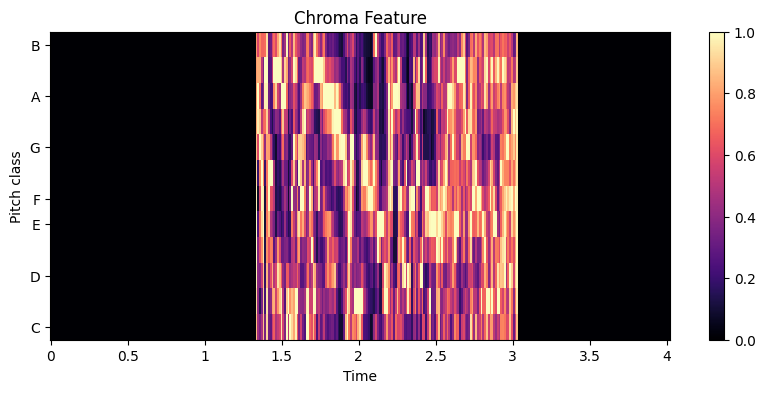

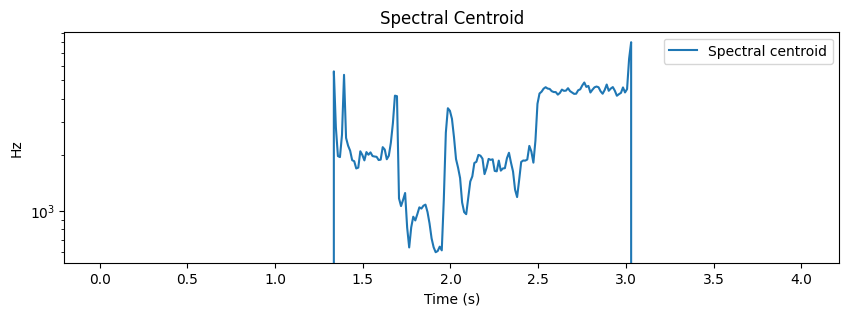

/tmp/ipython-input-4283427226.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(file_path, sr=None, mono=mono)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


[LOAD] 095522040.m4a
 - shape: (177152,)
 - sample_rate: 44100


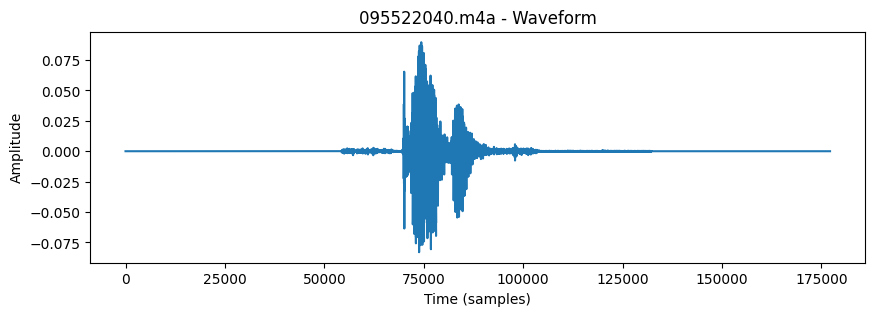

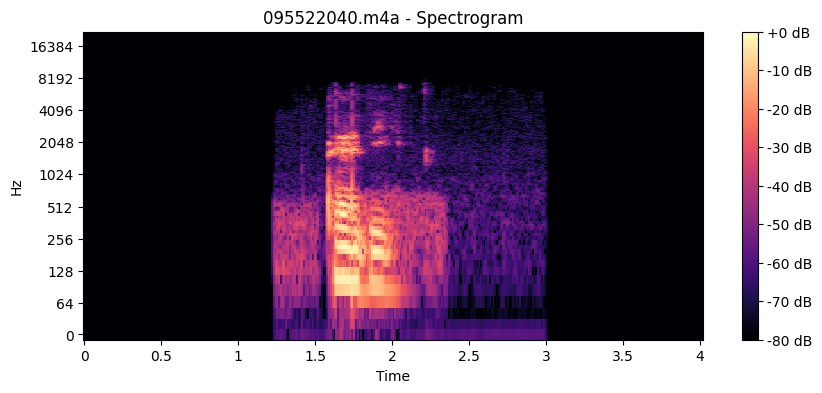

[RESAMPLE] 44100 Hz → 16000 Hz | shape: (64272,)
[RESAMPLE] 16000 Hz → 44100 Hz | shape: (177149,)


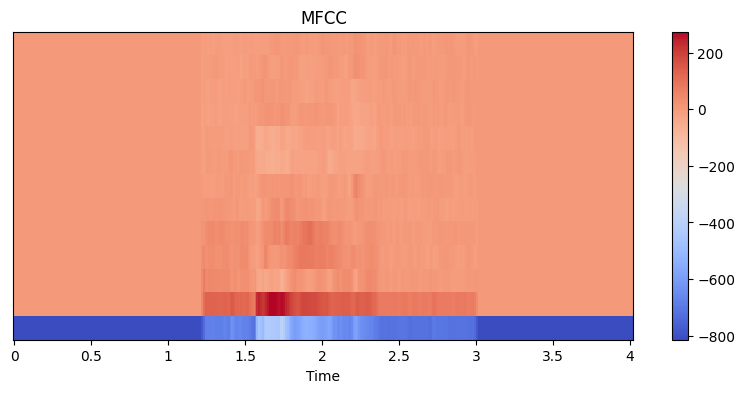

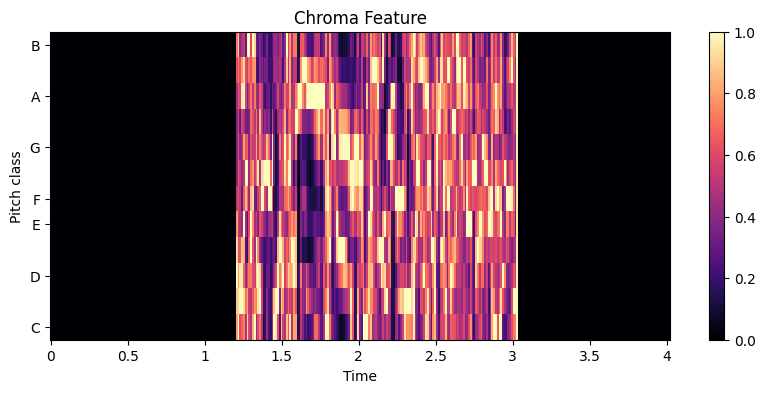

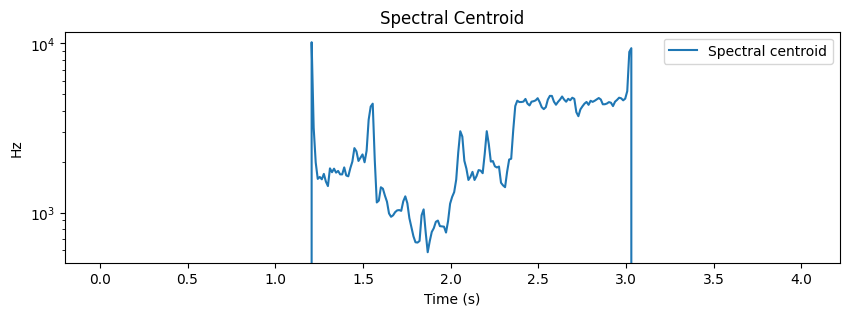

/tmp/ipython-input-4283427226.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(file_path, sr=None, mono=mono)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


[LOAD] 095522041.m4a
 - shape: (177152,)
 - sample_rate: 44100


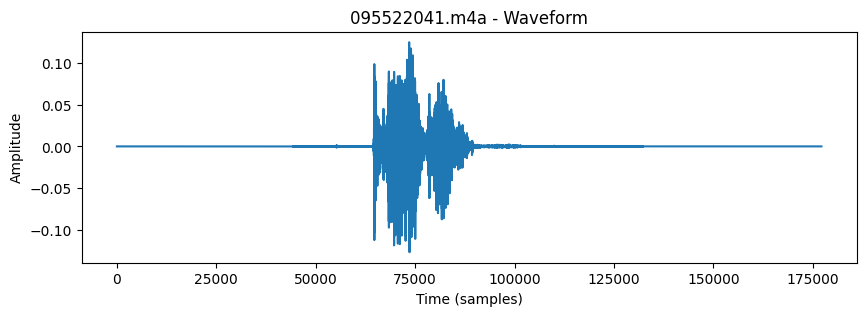

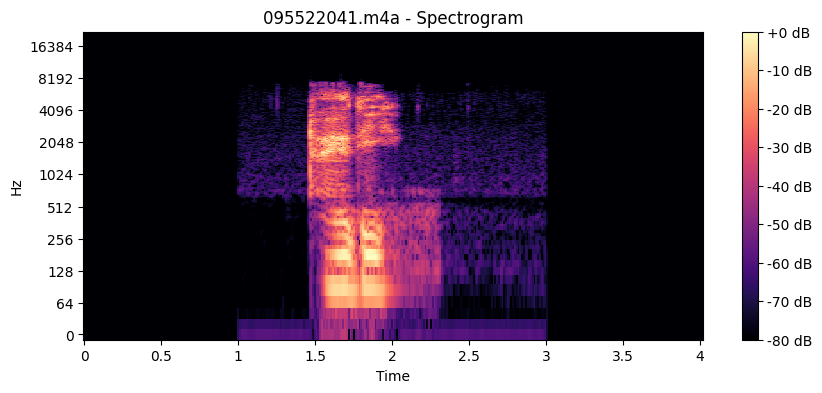

[RESAMPLE] 44100 Hz → 16000 Hz | shape: (64272,)
[RESAMPLE] 16000 Hz → 44100 Hz | shape: (177149,)


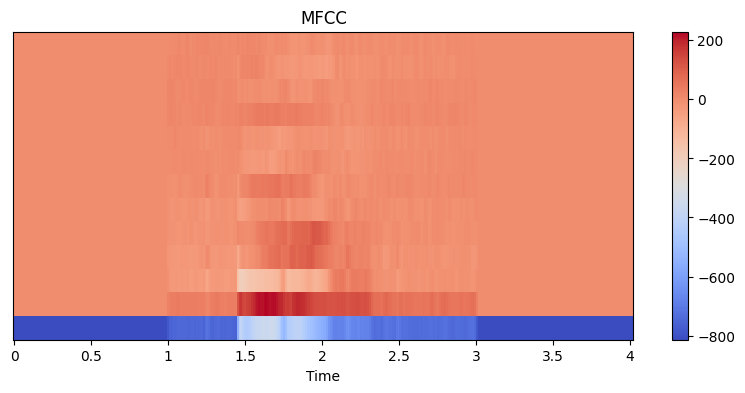

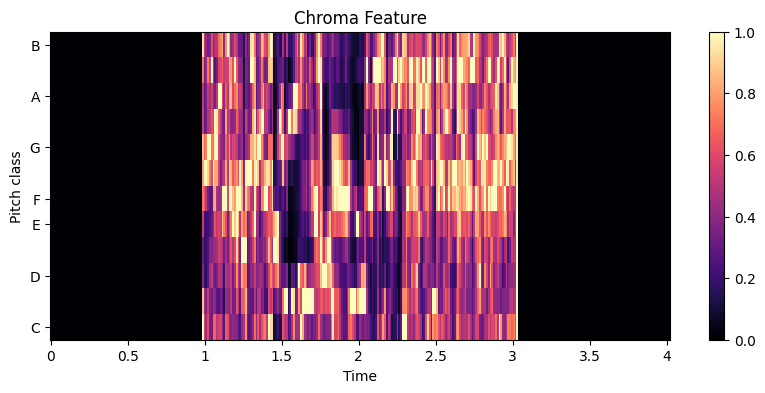

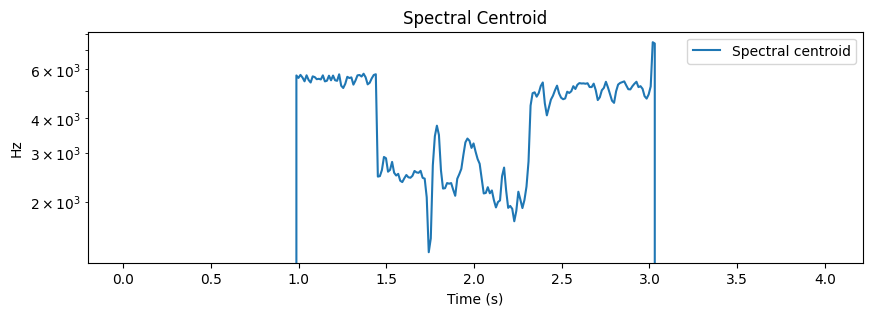

/tmp/ipython-input-4283427226.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(file_path, sr=None, mono=mono)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


[LOAD] 095522042.m4a
 - shape: (177152,)
 - sample_rate: 44100


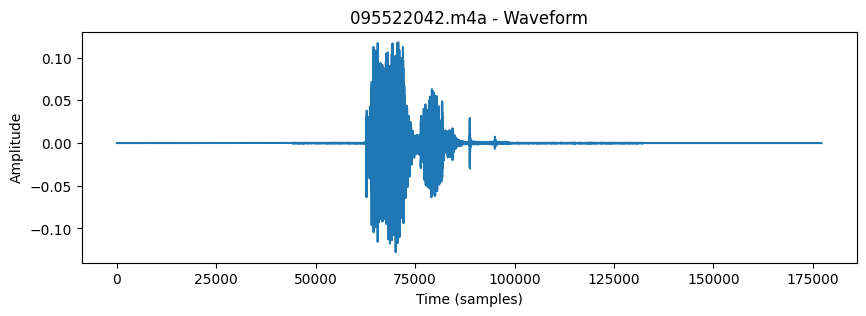

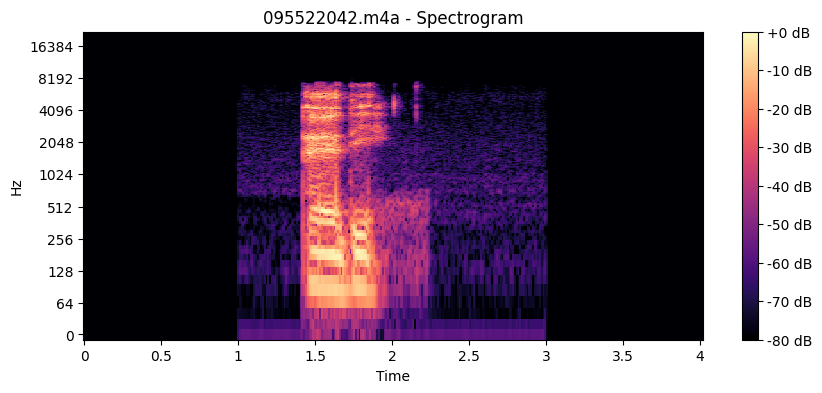

[RESAMPLE] 44100 Hz → 16000 Hz | shape: (64272,)
[RESAMPLE] 16000 Hz → 44100 Hz | shape: (177149,)


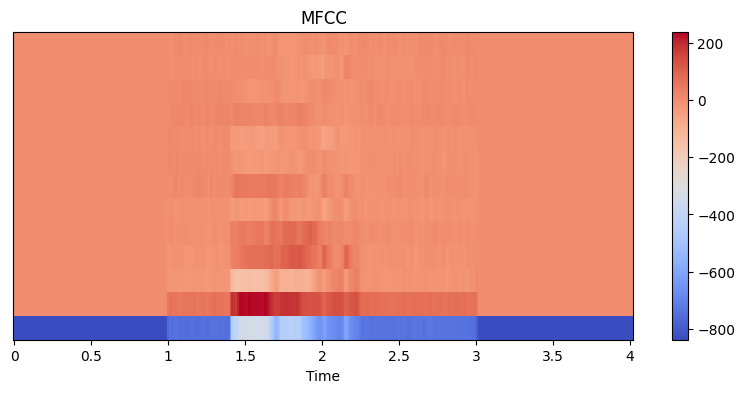

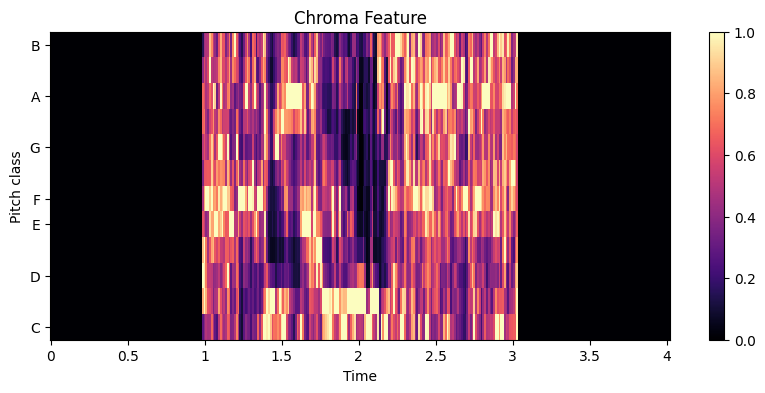

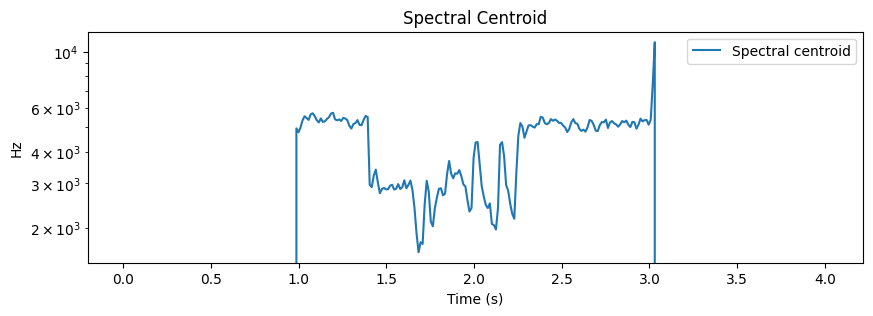

In [8]:
import librosa
import librosa.display
import torch
import matplotlib.pyplot as plt
import numpy as np
import resampy
from IPython.display import Audio


def load_audio(file_path, mono=True):
    """Load audio file with librosa"""
    waveform, sample_rate = librosa.load(file_path, sr=None, mono=mono)
    print(f"[LOAD] {file_path}")
    print(" - shape:", waveform.shape)
    print(" - sample_rate:", sample_rate)
    return waveform, sample_rate


def plot_waveform(waveform, title="Waveform"):
    """Plot raw waveform"""
    plt.figure(figsize=(10, 3))
    plt.plot(waveform)
    plt.title(title)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


def plot_spectrogram(waveform, sample_rate, title="Spectrogram"):
    """Plot log-scale spectrogram"""
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()


def play_audio(waveform, sample_rate):
    """Play audio inside notebook"""
    return Audio(waveform, rate=sample_rate)


def resample_audio(waveform, orig_sr, target_sr):
    """Down/Up sample waveform"""
    resampled = resampy.resample(waveform, orig_sr, target_sr)
    print(f"[RESAMPLE] {orig_sr} Hz → {target_sr} Hz | shape: {resampled.shape}")
    return resampled


def extract_mfcc(waveform, sample_rate, n_mfcc=13):
    """Extract MFCC features"""
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=n_mfcc)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sample_rate)
    plt.colorbar()
    plt.title("MFCC")
    plt.show()
    return mfcc


def extract_chroma(waveform, sample_rate):
    """Extract Chroma feature"""
    chroma = librosa.feature.chroma_stft(y=waveform, sr=sample_rate)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sample_rate)
    plt.colorbar()
    plt.title("Chroma Feature")
    plt.show()
    return chroma


def extract_spectral_centroid(waveform, sample_rate):
    """Extract Spectral Centroid"""
    centroid = librosa.feature.spectral_centroid(y=waveform, sr=sample_rate)[0]
    frames = range(len(centroid))
    t = librosa.frames_to_time(frames, sr=sample_rate)
    plt.figure(figsize=(10, 3))
    plt.semilogy(t, centroid, label='Spectral centroid')
    plt.xlabel('Time (s)')
    plt.ylabel('Hz')
    plt.title("Spectral Centroid")
    plt.legend()
    plt.show()
    return centroid


track = ["095522039", "095522040", "095522041", "095522042"]

for i in track:
    file_path = i + ".m4a"

    # 1. Load
    waveform, sr = load_audio(file_path)

    # 2. Waveform & Spectrogram
    plot_waveform(waveform, title=f"{i}.m4a - Waveform")
    plot_spectrogram(waveform, sr, title=f"{i}.m4a - Spectrogram")
    display(play_audio(waveform, sr))

    # 3. Down/Up sampling
    down_waveform = resample_audio(waveform, sr, 16000)
    up_waveform = resample_audio(down_waveform, 16000, sr)

    # 4. Feature extraction
    mfcc = extract_mfcc(waveform, sr)
    chroma = extract_chroma(waveform, sr)
    centroid = extract_spectral_centroid(waveform, sr)
